In [19]:
from requests import get
from bs4 import BeautifulSoup
from warnings import warn
from time import sleep
from random import randint
import numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pages = np.arange(1, 1000, 50)
headers = {'Accept-Language': 'en-US,en;q=0.8'}

In [3]:
titles = []
years = []
ratings = []
genres = []
runtimes = []
imdb_ratings = []
imdb_ratings_standardized = []
metascores = []
votes = []

for page in pages:
    response = get("https://www.imdb.com/search/title?genres=sci-fi&"
                   +"start="
                   + str(page)
                   + "&explore=title_type,genres&ref_=adv_prv", headers=headers)
    sleep(randint(8,15))
    
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')
    
    for container in movie_containers:
        if container.find('div', class_ = 'ratings-metascore') is not None:
            title = container.h3.a.text
            titles.append(title)
            
            
            if container.h3.find('span', class_= 'lister-item-year text-muted unbold') is not None:
                year = container.h3.find('span', class_= 'lister-item-year text-muted unbold').text
                years.append(year)
                
            else:
                years.append(None)
                
            if container.p.find('span', class_ = 'certificate') is not None:
                
                rating = container.p.find('span', class_= 'certificate').text
                ratings.append(rating)
            else:
                ratings.append("")
            
            if container.p.find('span', class_ = 'genre') is not None:
                genre = container.p.find('span', class_ = 'genre').text.replace("\n", "").rstrip().split(',')
                genres.append(genre)
            
            else:
                genres.append("")
                
            if container.p.find('span', class_ = 'runtime') is not None:
                time = int(container.p.find('span', class_ = 'runtime').text.replace(" min", ""))
                runtimes.append(time)
                
            else:
                runtimes.append(None)
                
            if float(container.strong.text) is not None:
                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)
            else:
                imdb_ratings.append(None)
                
            if container.find('span', class_ = 'metascore').text is not None:
                m_score = int(container.find('span', class_ = 'metascore').text)
                metascores.append(m_score)
            else:
                metascores.append(None)
                
            if container.find('span', attrs = {'name':'nv'})['data-value'] is not None:
                vote = int(container.find('span', attrs = {'name':'nv'})['data-value'])
                votes.append(vote)
            else:
                votes.append(None)

In [4]:
sci_fi_df = pd.DataFrame({'movie': titles,
                      'year': years,
                      'rating': ratings,
                      'genre': genres,
                      'runtime_min': runtimes,
                      'imdb': imdb_ratings,
                      'metascore': metascores,
                      'votes': votes}
                      )

sci_fi_df.loc[:, 'year'] = sci_fi_df['year'].str[-5:-1] # two more data transformations after scraping
# Drop 'ovie' bug
# Make year an int
sci_fi_df['n_imdb'] = sci_fi_df['imdb'] * 10
final_df = sci_fi_df.loc[sci_fi_df['year'] != 'ovie'] # One small issue with the scrape on these two movies so just dropping those ones.
final_df.loc[:, 'year'] = pd.to_numeric(final_df['year'])

C:\Users\User\AppData\Local\Temp\ipykernel_3508\1617373556.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[:, 'year'] = pd.to_numeric(final_df['year'])


In [12]:
movie_df = final_df.sort_values(by='year',ascending=True).reset_index(drop=True)
movie_df.index += 1
movie_df

,movie,year,rating,genre,runtime_min,imdb,metascore,votes,n_imdb
1,Metropolis,1927,Not Rated,"[Drama, Sci-Fi]",153,8.3,98,175460,83.0
2,Forbidden Planet,1956,G,"[Adventure, Sci-Fi]",98,7.5,80,50155,75.0
3,Planet of the Apes,1968,G,"[Adventure, Sci-Fi]",112,8.0,79,181582,80.0
4,2001: A Space Odyssey,1968,G,"[Adventure, Sci-Fi]",149,8.3,84,670179,83.0
5,Barbarella,1968,Approved,"[Adventure, Comedy, Fantasy]",98,5.8,51,35474,58.0
...,...,...,...,...,...,...,...,...,...
589,Minions: The Rise of Gru,2022,PG,"[Animation, Adventure, Comedy]",87,6.6,56,63845,66.0
590,Moonfall,2022,PG-13,"[Action, Adventure, Sci-Fi]",130,5.1,41,79590,51.0
591,Thor: Love and Thunder,2022,PG-13,"[Action, Adventure, Comedy]",118,6.3,57,325671,63.0
592,Nope,2022,R,"[Horror, Mystery, Sci-Fi]",130,6.9,77,176664,69.0


In [14]:
final_df.describe()

,year,runtime_min,imdb,metascore,votes,n_imdb
count,593.000000,593.000000,593.000000,593.00000,5.930000e+02,593.000000
mean,2006.703204,113.627319,6.575548,57.34570,2.763970e+05,65.755481
std,13.512367,19.817266,0.968608,16.10555,2.925835e+05,9.686082
min,1927.000000,60.000000,1.900000,10.00000,1.076000e+03,19.000000
25%,1999.000000,100.000000,5.900000,45.00000,7.770900e+04,59.000000
50%,2011.000000,111.000000,6.600000,58.00000,1.789580e+05,66.000000
75%,2017.000000,124.000000,7.200000,69.00000,3.789910e+05,72.000000
max,2022.000000,242.000000,8.800000,98.00000,2.348244e+06,88.000000


In [15]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 593 entries, 0 to 593
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        593 non-null    object 
 1   year         593 non-null    int64  
 2   rating       593 non-null    object 
 3   genre        593 non-null    object 
 4   runtime_min  593 non-null    int64  
 5   imdb         593 non-null    float64
 6   metascore    593 non-null    int64  
 7   votes        593 non-null    int64  
 8   n_imdb       593 non-null    float64
dtypes: float64(2), int64(4), object(3)
memory usage: 46.3+ KB


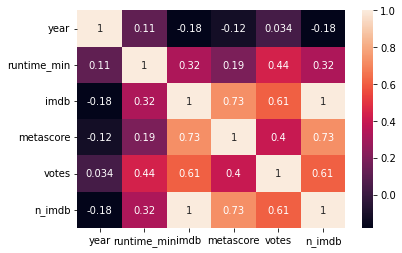

In [16]:
sns.heatmap(final_df.corr(), annot=True);

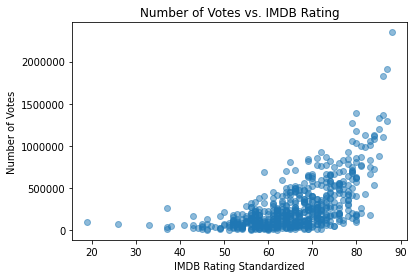

In [20]:
x = final_df['n_imdb']
y = final_df['votes']
plt.scatter(x, y, alpha=0.5) # s= is size var, c= is color var
plt.xlabel("IMDB Rating Standardized")
plt.ylabel("Number of Votes")
plt.title("Number of Votes vs. IMDB Rating")
plt.ticklabel_format(style='plain')
plt.show()